# Composite Full Ensemble

Date: Oct. 12th, 2017

This is now a full python script. This notebook is used to analyze the results.

In [1]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import esmtools as et
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import signal
import cmocean.cm as cm
import seaborn as sns

/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


# Load in the composites

In [2]:
def load_composite(EBU, VAR, MODE, full_domain=False, native_grid=False):
    """
    Load in the results of compositing. Full_domain will give the full
    composited domain from the analysis script; otherwise it will slice it 
    down to the domain used in evaluation plots.
    """
    filepath = ('/glade/work/rbrady/EBUS_BGC_Variability/composites/' + 
            EBU + '/' + VAR + '/')
    if native_grid:
        filename = VAR + '.native.composite.NPGO.nc'
    else:
        filename = (VAR + '.remapped.composite.' + MODE + '.nc')
    ds = xr.open_dataset(filepath + filename)
    
    # Conversions
    if VAR == 'PSL':
        ds = ds / 100
    if VAR == 'HMXL':
        ds = ds / 100
    if VAR == 'WVEL50m':
        ds = ds * (60*60*24) / 100
        ds = ds.squeeze()
        
    # Slicing
    if not full_domain:
        if EBU == 'CanCS':
            x0,x1,y0,y1 = et.ebus.visual_bounds(EBU, std_lon=True) 
        else:
            x0,x1,y0,y1 = et.ebus.visual_bounds(EBU, std_lon=False)           
        if native_grid:
            a, c = et.filtering.find_indices(ds['TLAT'].values, ds['TLONG'].values, 
                                y0, x0)
            b, d = et.filtering.find_indices(ds['TLAT'].values, ds['TLONG'].values, 
                                y1, x1)
            ds = ds.isel(nlat=slice(a, b), nlon=slice(c, d))
        else:
            ds = ds.sel(lat=slice(y0,y1), lon=slice(x0-3,x1))
    return ds

## Zoomed in Map

In [500]:
EBU = 'CanCS'
VAR = 'WVEL50m'
MODE = 'NAO'
ds = load_composite(EBU, VAR, MODE, native_grid=False)

In [501]:
def pcolor_subplot(ax, ds, vmin=-4, vmax=4, levels=21, cmap="coolwarm",
                   native_grid=False):
    if native_grid:
        p = ax.contourf(ds.TLONG, ds.TLAT, ds, np.linspace(vmin, vmax, levels),
                        transform=ccrs.PlateCarree(), cmap=cmap)
    else:
        p = ds.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
                             levels=np.linspace(vmin, vmax, levels), cmap=cmap,
                             extend="both")

    ax.add_feature(cfeature.LAND, facecolor='k', zorder=4)
    ax.outline_patch.set_edgecolor('w')
    return p

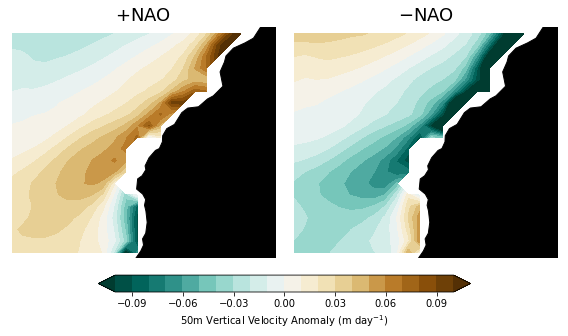

In [503]:
MINBOUND = -0.1
MAXBOUND = 0.1
cmap = "BrBG_r"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,5), 
                         subplot_kw=dict(projection=ccrs.PlateCarree()))
# POSITIVE MODE
pcolor_subplot(axes[0], ds.pos_composite, vmin=MINBOUND, vmax=MAXBOUND,
               cmap=cmap)
axes[0].set_title('$+$NAO', fontsize=18)

# NEGATIVE MODE
p = pcolor_subplot(axes[1], ds.neg_composite, vmin=MINBOUND, vmax=MAXBOUND,
                   cmap=cmap)
axes[1].set_title('$-$NAO', fontsize=18)

# Viewing bounds.
x0,x1,y0,y1 = et.ebus.visual_bounds(EBU)  
axes[0].set_extent([x0-3,x1,y0,y1])
axes[1].set_extent([x0-3,x1,y0,y1])

# COLORBAR
fig.tight_layout()
cb = fig.colorbar(p, ax=axes.ravel().tolist(), orientation='horizontal',
             fraction=0.05, pad=0.05)

if VAR == 'SST':
    cb.set_label('Sea Surface Temperature Anomaly ($^{o}$C)')
elif VAR == 'PSL':
    cb.set_label('Sea Level Pressure Anomaly (hPa)')
elif VAR == 'curl':
    cb.set_label('Wind Stress Curl Anomaly (N/m$^{2}$)')
elif VAR == 'HMXL':
    cb.set_label('Mixed Layer Depth Anomaly (m)')
elif VAR == 'SSH':
    cb.set_label('Sea Surface Height Anomaly (cm)')
elif VAR == 'WVEL50m':
    cb.set_label('50m Vertical Velocity Anomaly (m day$^{-1}$)')
elif VAR == 'DIC50m':
    cb.set_label('50m Dissolved Inorganic Carbon Anomaly (mmol m$^{-3}$)')
    
#et.vis.savefig(VAR + '_' + MODE.lower() + '_' + EBU + '_zoomed', 
#               extension='.eps', dpi=300)

## Native grid, box boundary

In [504]:
EBU = 'CanCS'
VAR = 'WVEL50m'
MODE = 'NAO'
ds = load_composite(EBU, VAR, MODE, native_grid=False)
ds_outline = xr.open_dataset('/glade/work/rbrady/EBUS_BGC_Variability/HMXL/' + 
                              EBU + '/filtered_output/' +
                             EBU.lower() + '-HMXL-forced-signal-chavez-800km.nc')

# Add a constant color grid
dshape = ds_outline['HMXL'].shape
A = np.empty((dshape))
A[:] = 999
A[np.isnan(ds_outline['HMXL'])] = np.nan
ds_outline['outline'] = (('time','nlat','nlon'), A)

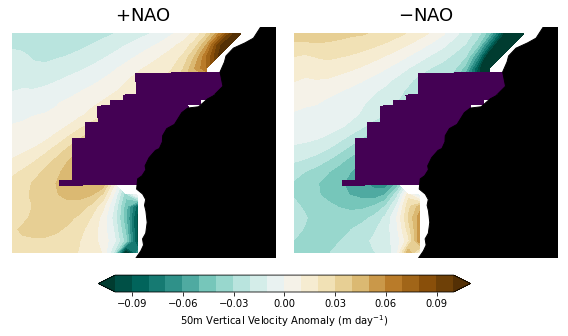

In [506]:
MINBOUND = -0.1
MAXBOUND = 0.1
cmap = "BrBG_r"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,5), 
                         subplot_kw=dict(projection=ccrs.PlateCarree()))
# POSITIVE MODE
pcolor_subplot(axes[0], ds.pos_composite, vmin=MINBOUND, vmax=MAXBOUND, cmap=cmap)
axes[0].set_title('$+$NAO', fontsize=18)

# NEGATIVE MODE
p = pcolor_subplot(axes[1], ds.neg_composite, vmin=MINBOUND, vmax=MAXBOUND, cmap=cmap)
axes[1].set_title('$-$NAO', fontsize=18)

# Viewing bounds.
x0,x1,y0,y1 = et.ebus.visual_bounds(EBU)  
axes[0].set_extent([x0-3,x1,y0,y1])
axes[1].set_extent([x0-3,x1,y0,y1])

# Overlay region for illustrator
axes[0].pcolormesh(ds_outline.TLONG, ds_outline.TLAT, ds_outline.outline.isel(time=0),
           transform=ccrs.PlateCarree())
axes[1].pcolormesh(ds_outline.TLONG, ds_outline.TLAT, ds_outline.outline.isel(time=0),
           transform=ccrs.PlateCarree())

# COLORBAR
fig.tight_layout()
cb = fig.colorbar(p, ax=axes.ravel().tolist(), orientation='horizontal',
             fraction=0.05, pad=0.05)

if VAR == 'SST':
    cb.set_label('Sea Surface Temperature Anomaly ($^{o}$C)')
elif VAR == 'PSL':
    cb.set_label('Sea Level Pressure Anomaly (hPa)')
elif VAR == 'curl':
    cb.set_label('Wind Stress Curl Anomaly (N/m$^{2}$)')
elif VAR == 'HMXL':
    cb.set_label('Mixed Layer Depth Anomaly (m)')
elif VAR == 'SSH':
    cb.set_label('Sea Surface Height Anomaly (cm)')
elif VAR == 'WVEL50m':
    cb.set_label('50m Vertical Velocity Anomaly (m day$^{-1}$)')
elif VAR == 'DIC50m':
    cb.set_label('50m Dissolved Inorganic Carbon Anomaly (mmol m$^{-3}$)')
    
#et.vis.savefig(VAR + '_' + MODE.lower() + '_' + EBU + '_zoomed_with_box',
#               extension='.eps', dpi=300)

# Visualize Vectors

In [532]:
def vector_subplot(ax, ds, dax, day, num=3, vmin=-5e-8, vmax=5e-8,
                   levels=21, cmap="BrBG_r"):
    dax = et.vis.meshgrid(dax['lon'], dax['lat'], dax)
    day = et.vis.meshgrid(day['lon'], day['lat'], day)
    ##############
    p = ds.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
                         levels=np.linspace(vmin, vmax, levels), cmap=cmap)
#    q = ax.quiver(dax.gridlon[::num], dax.gridlat[::num], dax[::num,::num], day[::num,::num],
#                  pivot='mid',  scale_units='inches', scale=0.75)
    q = ax.quiver(dax.gridlon[::num,::num].values, dax.gridlat[::num,::num].values, 
                  dax[::num,::num].values, 
                  day[::num,::num].values, 
                  transform=ccrs.PlateCarree(), pivot='mid',
                  scale_units='inches', scale=1.00)
    qk = plt.quiverkey(q, 0.8,0.7, 0.1, r'$0.1 \frac{dyn}{cm^{2}}$', labelpos='E',
                   coordinates='axes',labelcolor='w',color='w')
    
    ax.add_feature(cfeature.LAND, facecolor='k', zorder=4)
    ax.outline_patch.set_edgecolor('w')
    
    return p, q

In [533]:
EBU = 'CanCS'
MODE = 'NAO'

In [534]:
ds = load_composite(EBU, 'curl', MODE)
dsx = load_composite(EBU, 'TAUX', MODE)
dsy = load_composite(EBU, 'TAUY', MODE)

/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


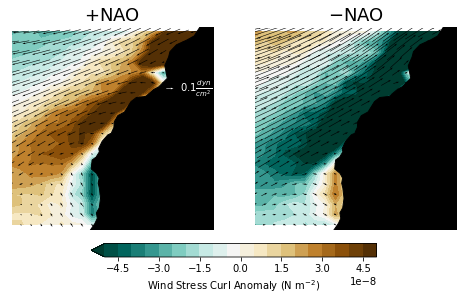

In [536]:
f, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,5),
                    subplot_kw=dict(projection=ccrs.PlateCarree()))

# Positive
p, q = vector_subplot(ax[0],ds['pos_composite'],dsx['pos_composite'],dsy['pos_composite'],num=1)
ax[0].set_title('$+$NAO', fontsize=18)

# Negative
p, q = vector_subplot(ax[1],ds['neg_composite'],dsx['neg_composite'],dsy['neg_composite'],num=1)
ax[1].set_title('$-$NAO', fontsize=18)

# Viewing bounds.
x0,x1,y0,y1 = et.ebus.visual_bounds(EBU)  
ax[0].set_extent([x0,x1,y0,y1])
ax[1].set_extent([x0,x1,y0,y1])

# Colorbar
fig.tight_layout()
cb = fig.colorbar(p, ax=ax.ravel().tolist(), orientation='horizontal',
             fraction=0.05, pad=0.05)
cb.set_label('Wind Stress Curl Anomaly (N m$^{-2}$)')

#et.vis.savefig('stress_and_curl_' + MODE.lower() + '_' + EBU, 
#               extension='.eps', dpi=300)

## Box out appropriate region

In [537]:
EBU = 'CanCS'
MODE = 'NAO'

In [538]:
ds = load_composite(EBU, 'curl', MODE)
dsx = load_composite(EBU, 'TAUX', MODE)
dsy = load_composite(EBU, 'TAUY', MODE)
ds_outline = xr.open_dataset('/glade/work/rbrady/EBUS_BGC_Variability/HMXL/' + 
                              EBU + '/filtered_output/' +
                             EBU.lower() + '-HMXL-forced-signal-chavez-800km.nc')

# Add a constant color grid
dshape = ds_outline['HMXL'].shape
A = np.empty((dshape))
A[:] = 999
A[np.isnan(ds_outline['HMXL'])] = np.nan
ds_outline['outline'] = (('time','nlat','nlon'), A)

/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


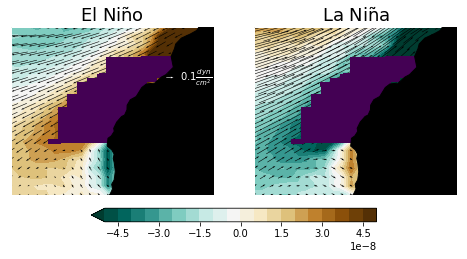

In [540]:
f, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,5),
                    subplot_kw=dict(projection=ccrs.PlateCarree()))

# Positive
p, q = vector_subplot(ax[0],ds['pos_composite'],dsx['pos_composite'],dsy['pos_composite'],num=1)
ax[0].set_title('El $\mathrm{Ni\~no}$', fontsize=18)

# Negative
p, q = vector_subplot(ax[1],ds['neg_composite'],dsx['neg_composite'],dsy['neg_composite'],num=1)
ax[1].set_title('La $\mathrm{Ni\~na}$', fontsize=18)

# Colorbar
fig.tight_layout()
cb = fig.colorbar(p, ax=ax.ravel().tolist(), orientation='horizontal',
             fraction=0.05, pad=0.05)

# Overlay region for illustrator
ax[0].pcolormesh(ds_outline.TLONG, ds_outline.TLAT, ds_outline.outline.isel(time=0),
           transform=ccrs.PlateCarree())
ax[1].pcolormesh(ds_outline.TLONG, ds_outline.TLAT, ds_outline.outline.isel(time=0),
           transform=ccrs.PlateCarree())


#et.vis.savefig('stress_and_curl_' + MODE.lower() + '_' + EBU + '_box', 
#               extension='.eps', dpi=300)

# Mode's Basin-Scale Impacts

Having trouble plotting vectors over maps on this scale so will just make two maps
then combine them in Illustrator.

In [3]:
EBU = 'CanCS'
MODE = 'NAO'

In [19]:
def vector_subplot_large(ax, ds, dax, day, num=2, vmin=-2, vmax=2,
                   levels=21, cmap="BrBG_r"):
    dax = et.vis.meshgrid(dax['lon'],dax['lat'],dax)
    day = et.vis.meshgrid(day['lon'],day['lat'],day)
    ##############
    p = ds.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
                         levels=np.linspace(vmin, vmax, levels), cmap=cmap)
    q = ax.quiver(dax.gridlon[::num,::num].values, dax.gridlat[::num,::num].values, 
                  dax[::num,::num].values, 
                  day[::num,::num].values, 
                  transform=ccrs.PlateCarree(), pivot='mid',
                  scale_units='inches', scale=1.5)
    qk = plt.quiverkey(q, 0.75,0.5, 0.25, r'$0.25 \frac{dyn}{cm^{2}}$', labelpos='E',
                   coordinates='axes',labelcolor='w',color='w', zorder=4)
    
    ax.add_feature(cfeature.LAND, facecolor='k', zorder=1)
    ax.outline_patch.set_edgecolor('w')
    x0,x1,y0,y1 = et.ebus.visual_bounds(EBU, std_lon=True)
    et.vis.add_box(ax, x0, x1, y0, y1, edgecolor='k', facecolor='w',
                   alpha=0.5, zorder=1)
    return p, q

In [20]:
ds = load_composite(EBU, 'SSH', MODE, full_domain=True)
dax = load_composite(EBU, 'TAUX', MODE, full_domain=True)
day = load_composite(EBU, 'TAUY', MODE, full_domain=True)

/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


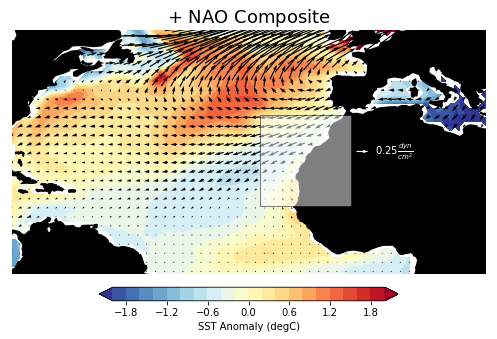

In [21]:
f, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,5),
                    subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)))

# Positive
p, q = vector_subplot_large(ax, ds.pos_composite, dax.pos_composite, 
                            day.pos_composite, cmap="RdYlBu_r", num=2)
ax.set_title('$+$ NAO Composite', fontsize=18)

cb = plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.05)
cb.set_label('SST Anomaly (degC)')

ax.set_extent([-80, 25, 0, 40])

#et.vis.savefig('north_atlantic_' + MODE + '_composite', extension='.eps', dpi=300)